<a href="https://colab.research.google.com/github/mcroning/Nonlinear-Beam-Propagation/blob/main/PRcoupler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3D photorefractive steady state and time dependent beam propagation code

In [1]:
import sys
import numpy as np
import cupy as cp
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets
from cupyx.scipy.ndimage import zoom, gaussian_filter
from scipy.ndimage import gaussian_filter as gaussian_filter_cpu
from scipy.ndimage import zoom as zoom_cpu
import cupyx.scipy.fft as spfft
from cupy import NaN
import os
from os.path import exists
from imageio.v2 import imread
from scipy.optimize import curve_fit
from scipy.signal.windows import tukey
# modules for output display
from matplotlib import rcParams
import matplotlib.animation as animation
import matplotlib.colors as colors
from PIL import Image, ImageChops
from IPython import display as ipydisplay
from IPython.display import clear_output as ipyclear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
from cProfile import Profile
from pstats import SortKey, Stats

In [2]:
# @title Functions
def params(value,description,description_tooltip,disabled):
  """
  generate widgets for input float parameters
  Args:
    value: default value
    description: widget description
    description_tooltip: widget tooltip also variable name
    disabled: widget disabled

  Returns:
    widg: widget

  """
  prdata[description_tooltip]=value
  style={'description_width':'initial'}
  widg=widgets.FloatText(value=value,description=description,
                         description_tooltip=description_tooltip,disabled=disabled,style=style)
  display(widg)
  return widg
def intparams(value,description,description_tooltip,disabled):
  """
  generate widgets for input integer parameters
  Args:
    value: default value
    description:  widget description
    description_tooltip:  widget tooltip also variable name
    disabled: widget disabled

  Returns:
    widg: widget
  """
  prdata[description_tooltip]=value
  style={'description_width':'initial'}
  widg=widgets.IntText(value=value,description=description,
                       description_tooltip=description_tooltip,
                       disabled=disabled,style=style)
  display(widg)
  return widg
def checkbox(value,description,description_tooltip,disabled):
  """
  generate widgets for input boolean parameters
  Args:
    value:  default value (True or False)
    description:      widget description
    description_tooltip:  widget tooltip also variable name
    disabled: widget disabled

  Returns:
    widg: widget
  """

  prdata[description_tooltip]=value
  style={'description_width':'initial'}
  widg=widgets.Checkbox(value=value,description=description,
                        description_tooltip=description_tooltip,
                        disabled=disabled,style=style)
  display(widg)
  return widg
def dropdown(option,value,description,disabled,description_tooltip):
  """
  generate widgets for input dropdown parameters
  Args:
    option: list of options
    value:  default value
    description: widget description
    disabled:  widget disabled
    description_tooltip:  widget tooltip also variable name

  Returns:
    widg: widget
  """

  prdata[description_tooltip]=value
  style={'description_width':'initial'}
  widg=widgets.Dropdown(
    options=option,
    value=value,
    description=description,
    disabled=False,description_tooltip=description_tooltip,style=style
  )
  display(widg)
  return widg

def text_entry(value,placeholder,description,description_tooltip,disabled):
  """
  generate widgets for input text parameters
  Args:
    value: default value
    placeholder:  widget text box placeholder
    description:  widget description
    description_tooltip:  widget tooltip also variable name
    disabled: widget disabled

  Returns:
    widg: widget
  """
  prdata[description_tooltip]=value
  style={'description_width':'initial'}
  widg=widgets.Text(value=value,placeholder=placeholder,description=description,
                         description_tooltip=description_tooltip,disabled=disabled,style=style)
  display(widg)
  return widg

# @title input amplitude generation functions
#ampxz: transverse amplitude cross section sampleed every fourth step (complex) [nsteps//4,xsamp,ysamp]
#imout_final: square sample of output on beam 1 (positive frequencies) (currently size yaper/2)
#imin: input intensity matching imout_final
#gain: calculated coupling gain for two beam coupling
#ift: far field intensity (float) [nsteps,xsamp,ysamp]
#prdata: dictionary containing variables and parameters

def genrot(rlen,thout,phi,x,y):
  """

  Args:
    rlen: crystal length (um)
    thout: beam input polar angle radians, 0 for normal incidence
    phi: beam azimuth, zero for beam in xz plane
    x: crystal coordinates array 1D float
    y: crystal coordinates array 1D float

  Returns: rotated coordinates xp,yp,zp 1D arrays used in beam genearator gaus

  """

  #generate coordinate frames rotated by input angles
  xs=len(x)
  ys=len(y)
  xp=cp.zeros((xs,ys))
  yp=cp.zeros((xs,ys))
  zp=cp.zeros((xs,ys))
  el=rlen/2.0 #half interaction length
  th=cp.arcsin(cp.sin(thout)/refin) #internal propagation angle
  sP=cp.sin(phi)
  cP=cp.cos(phi)
  st=cp.sin(th)
  ct=cp.cos(th)
  s2p=2*sP*cP
  c2p=cP**2-sP**2
  xp=x[:,None]+cP*(1-ct)*(-x[:,None]*cP+y[None,:]*sP)-el*cP*st
  yp=y[None,:]+sP*(1-ct)*(x[:,None]*cP-y[None,:]*sP)+el*sP*st
  zp=(-el)*ct+(-x[:,None]*cP+y[None,:]*sP)*st
  return xp,yp,zp

def gaus(coord,beam,arrin,w0x,w0y):
    """

    Args:
      x: input angle rotated x coordinate 1D array
      y: input angle rotated y coordinate 1D array
      z: input angle rotated z coordinate 1D array
      beam: beam number: 2 is pump for 2 beam coupling, 1 for beam 1 signal
      arrin: scaled input image 2D array
      w0x: beam waist in x
      w0y: beam waist in y

    Returns: amp: complex beam amplitude array

    """
    #apply image to gaussian beam focussing at longitudinal center of crystal
    # if called for by value in variable transp
    #x,y,z rotated coordinates, beam = beam number 1 or 2
    #w0x beam waist in x direction
    lm=prdata['lm']
    refin=prdata['refin']
    x,y,z=coord
    kin=refin*2*cp.pi/lm # wavenumber of beam inside crystal
    z0x=w0x**2*kin/2.0
    z0y=w0y**2*kin/2.0
    eta=(cp.arctan(z/z0x)+cp.arctan(z/z0y))/2
    #inverse radii of curvature
    rlxinv=z/(z**2+z0x**2)
    rlyinv=z/(z**2+z0y**2)
    #rlxinvmn=rlen/(rlen**2+z0x**2) #mean inverse radius of curvature
    wl2x=w0x**2*(1.0+(z/z0x)**2)
    wl2y=w0y**2*(1.0+(z/z0y)**2)
    wlxy=cp.sqrt((1.0+(z/z0x)**2)*(1.0+(z/z0y)**2))
    argx = (x**2)*(1.0/wl2x-1j*kin*rlxinv/2.0)
    argy = (y**2)*(1.0/wl2y-1j*kin*rlyinv/2.0)
    arg=argx+argy
    # w0x<0 is a switch for plane wave input
    if w0x > 0:
      amp1 = cp.exp(-arg+1j*kin*z-1j*eta)/cp.sqrt(wlxy)
    else:
      amp1 = cp.exp(+1j*kin*z)

    if beam == 1:
      transp=prdata['transp1']
    else:
      transp=prdata['transp2']

    phasetransp=prdata['realimage']=="phase image"  #apply data as phase transparency if false
    # beam may have the data transparency imposed
    if transp:
      #find beam centers
      lenx,leny=cp.shape(arrin)
      xindex1,yindex1=getx0y0(coord)

      if not phasetransp:
        amp1[xindex1-lenx//2:xindex1+lenx//2,yindex1-leny//2:yindex1+leny//2] \
          = arrin[:2*(lenx//2),:2*(leny//2)] \
          *amp1[xindex1-lenx//2:xindex1+lenx//2,yindex1-leny//2:yindex1+leny//2]
      else:
        amp1[xindex1-lenx//2:xindex1+lenx//2,yindex1-leny//2:yindex1+leny//2] \
          = cp.exp(1j*cp.pi*arrin[:2*(lenx//2),:2*(leny//2)]) \
          *amp1[xindex1-lenx//2:xindex1+lenx//2,yindex1-leny//2:yindex1+leny//2]

    return amp1

def a(arrin,coord1,coord2):
    """

    Args:
      arrin: scaled input image 2D array
      coord1: rotated coordinates for beam 1 2D array
      coord2: rotated coordinates for beam 2 2D array
    Returns: full input field amplitude

    """
    rat=prdata['rat'] #beam ratio
    #a1r=1.0/cp.sqrt(1.0+rat)
    #a2r=cp.sqrt(rat)/cp.sqrt(1.0+rat)
    a1r=cp.sqrt(1.0/(1.0+rat))
    a2r=cp.sqrt(rat/(1.0+rat))


    # for the moment the beams have equal waists in x and y
    w0x1=prdata['w01']
    w0y1=prdata['w01']
    w0x2=prdata['w02']
    w0y2=prdata['w02']
    # generate beams 1 and 2
    amp1=gaus(coord1,1,arrin,w0x1,w0y1)
    amp2=gaus(coord2,2,arrin,w0x2,w0y2)
    # add them according to beam ratio
    atot=a1r*amp1+a2r*amp2
    return atot
def getx0y0(coord):
  """

  Args:
    xp: input angle rotated x coordinates 1D array
    yp: input angle rotated y coordinates 1D array

  Returns: array indices at center of input beams 1 and 2

  """
  xp1=coord[0]
  yp1=coord[1]
  #find beam centers where xp and yp are zero
  x0,y0=cp.unravel_index(cp.argmin(xp1**2+yp1**2),(xsamp,ysamp))
  return (int(x0),int(y0))
def hidiff(ift):
  """
  Diagnostic to determine importance of artifact diffraction orders
  Arg:
    ift: far field intensity array

  Returns: fraction of output in 2nd order non Bragg matched beams

  """
  # routine to determine importance of artifact diffraction orders
  xsamp=prdata['xsamp'] ; ysamp=prdata['ysamp']
  xaper=prdata['xaper'] ; yaper=prdata['yaper']
  thout1=prdata['thout1'] ; thout2=prdata['thout2']
  phi1=prdata['phi1'] ; phi2=prdata['phi2']
  lm=prdata['lm']
  w01=prdata['w01']
  if w01 > 0:
    iwx=round(xaper/w01)
  else:
    iwx=4
  if w02 > 0:
    iwy=round(yaper/w01)
  else:
    iwy=4
  fx1=-np.cos(phi1)*np.sin(thout1)/lm
  fy1=np.sin(phi1)*np.sin(thout1)/lm
  fx2=-np.cos(phi2)*np.sin(thout2)/lm
  fy2=np.sin(phi2)*np.sin(thout2)/lm
  fx0=-xsamp/xaper/2 ; fy0=-ysamp/yaper/2
# p1,p2 indices of beam 1,2 in Fourier transform array
# p11,p21 indices of 1st higher order diff inbeam 1,2 in Fourier transform array
  p1=np.array((round((fx1-fx0)*xaper),round((fy1-fy0)*yaper)))
  p2=np.array((round((fx2-fx0)*xaper),round((fy2-fy0)*yaper)))
  p11=np.array((round((2*fx1-fx2-fx0)*xaper),round((2*fy1-fy2-fy0)*yaper)))
  p21=np.array((round((2*fx2-fx1-fx0)*xaper),round((2*fy2-fy1-fy0)*yaper)))
  s1=np.sum(ift[p1[0]+1-iwx:p1[0]+1+iwx,p1[1]+1-iwy:p1[1]+1+iwy])
  s11=np.sum(ift[p11[0]+1-iwx:p11[0]+1+iwx,p11[1]+1-iwy:p11[1]+1+iwy])
  s2=np.sum(ift[p2[0]+1-iwx:p2[0]+1+iwx,p2[1]+1-iwy:p2[1]+1+iwy])
  s21=np.sum(ift[p21[0]+1-iwx:p21[0]+1+iwx,p21[1]+1-iwy:p21[1]+1+iwy])
  hi_order_in_range_x= (iwx < p11[0] < (xsamp - iwx)) and (iwx < p21[0] < (xsamp - iwx))
  hi_order_in_range_y= (iwy < p11[1] < (ysamp - iwy)) and (iwy < p21[1] < (ysamp - iwy))

  #return fraction of artifact diffraction in output
  if hi_order_in_range_x and hi_order_in_range_y:
    return (s11+s21)/(s1+s2+s11+s21),p11,p1,p2,p21
  else:
    return -1,p11,p1,p2,p21

  #return cp.sum(ddt**2)


def esc_f(amp,fx,k0):
  """

  Static space charge: Simple version
  Args:
    amp: optical amplitude 2D complex array
    fx: array of spatial frequencies to generate spatial derivatives in FT space
    k0: characteristic space charge wave number

  Returns: space charge field

  """

  # full steady state space charge field
  intens2=abs(amp)**2
  id=prdata['Id']
  Ip=cp.real(spfft.ifft(1.0j*2*cp.pi*fx[:,None]*spfft.fft(intens2,axis=0),axis=0))/k0
  esc=-cp.real(spfft.ifft(-spfft.fft(Ip/(intens2+id),axis=0)/
   (1+(2.0*cp.pi*fx[:,None]/k0)**2),axis=0) )
  return esc

def esc_s(amp,fx,k0):
  """
  Static space charge: Simple version for plane waves
  Args:
    amp: optical amplitude 2D complex array
    fx: array of spatial frequencies to generate spatial derivatives in FT space
    k0: characteristic space charge wave number

  Returns: space charge field

  """
  #simple steady state space charge field
  intens2=abs(amp)**2
  Ip=cp.real(spfft.ifft(1.0j*2*cp.pi*fx[:,None]*spfft.fft(intens2,axis=0),axis=0))/k0
  return Ip/(1+(kg/k0)**2)

def dEdt_s(amp,fx,k0,escsa):
  """
  Time derivative of space charge field: simplified version linear in space
  charge field. For plane waves only.
  Args:
    amp: optical amplitude 2D complex array
    fx: array of spatial frequencies to generate spatial derivatives in FT space
    k0: characteristic space charge wave number
    escsa: space charge field

  Returns: time derivative of space charge field

  """
  intens2=abs(amp)**2
  # kg grating wavenumber
  kg=2*np.pi*(np.sin(prdata['thout1']-np.sin(prdata['thout2'])))/prdata['lm']
  Ip=cp.real(spfft.ifft(1.0j*2*cp.pi*fx[:,None]*spfft.fft(intens2,axis=0),axis=0))/k0
  return -escsa*(1+(kg/k0)**2) + Ip

def dEdt_f(amp,fx,k0,escsa):
  """
  Full theoretical time derivative of space charge field:
  Args:
    amp: optical amplitude 2D complex array
    fx:  array of spatial frequencies to generate spatial derivatives in FT space
    k0:  characteristic space charge wave number
    escsa: space charge field

  Returns: time derivative of space charge field

  """
  intens2=abs(amp)**2
  Ip=cp.real(spfft.ifft(1.0j*2*cp.pi*fx[:,None]*spfft.fft(intens2,axis=0),axis=0))/k0
  escft=spfft.fft(escsa,axis=0)
  # Calculate transverse derivative of space charge field from previous step
  escsp=cp.real(spfft.ifft((2j*cp.pi*fx[:,None]/k0)* escft ,axis=0))
  # Calculate second derivative of space charge field from previous step
  escspp=cp.real(spfft.ifft((2j*cp.pi*fx[:,None]/k0)**2* escft ,axis=0))
  ddt_raw = -((escsa*(intens2+Id)-Ip)*(1+escsp)-escspp*(intens2+Id))
  return ddt_raw


def dn_calc(escsa,amp):   ###simplified here in PRcoupler2
  """
  Photorefractive nonlinearity
  Args:
    escsa: space charge field
    kout: optical wavenumber outside crystal (refractive index 1)
    kt: Kerr coefficient, perhaps thermal. Not tested

  Returns: nonlinear refactive index grating (2D real array)

  """
  intens2=abs(amp)**2
  kt=prdata['kt']
  kout=2*cp.pi/prdata['lm']
  gl=prdata['gl'];rlen=prdata['rlen']
  dn = -escsa*2*gl/(rlen*kout)+kt*intens2*1e-3 #photorefractive index array

  return dn

def noisexy(m):
  xsamp=prdata['xsamp'] ; ysamp=prdata['ysamp'] ; yaper=prdata['yaper']
  xaper=prdata['xaper'] ; sigma=prdata['sigma'] ; eps=prdata['eps']
  rlen=prdata['rlen'] ; dz=prdata['dz']
  seeds=prdata['seeds']
  niter=int(rlen/dz)
  sigmax=sigma*xsamp/xaper
  sigmay=sigma*ysamp/yaper
  cp.random.seed(seeds[m])
  corrnoise1layer_a=cp.random.normal(loc=0,scale=np.sqrt(eps/niter*4*np.pi),size=(xsamp,ysamp))
  #corrnoise1layer=corrnoise1layer_a
  corrnoise1layer=gaussian_filter(corrnoise1layer_a,sigma=(sigmax,sigmay))*cp.sqrt(sigmax*sigmay)
  return corrnoise1layer

In [3]:

prdata={}
data_file_name=""
load_existing=input("Do you want to load existing parameters from Google Drive: y or n:")
if load_existing in ("y","Y","Yes","YES"):
  from google.colab import drive
  drive.mount('/content/drive')
  data_file_name=input("enter starting parameter file (npz): ")

Do you want to load existing parameters from Google Drive: y or n:n


In [5]:
# @title Load parameters from npz file if needed

if data_file_name != "":
  prdata=np.load(data_file_name,allow_pickle=True)["arr_0"].item()
  for item in prdata:
    value=prdata[item]
    varname=item
    if type(value)==str:
      exec('%s = "%s"' % (varname,value))
    elif type(value)==int:
      exec('%s = %d' % (varname,value))
    elif type(value)==bool:
      exec('%s = %s' % (varname,value))
    elif item=='seeds':
      seeds=prdata['seeds']

    elif type(value)==float:
      exec('%s = %f' % (varname,value))



In [6]:
# @title initialize default parameters
if prdata=={}:
  gl=-3.0;rat=1;image_size_factor=1;w01=100;w02=100;thout1=0.1;thout2=-0.1
  phi1=0;phi2=0;tend=10.0;batchnum_spec=1;NT=6.4e22;T=293;refin=2.4;epsr=2500
  Id=0.01;windowedge=0.1;sigma=0.4;eps=0.02;kt=0.0;image_size_factor=1
  xaper=1000;yaper=1000;xsamp=4096;ysamp=512;rlen=4000;dz=20;lm=0.633
  fanning_study=False;image_invert=False;backpropagate=False
  save_noise_seeds=False;use_old_seeds=False;folder='';savedata=False
  a0=1e-3 #tukey window absorption coefficient in um^-1
  time_behavior='Static'
  Eplane=False
  std_image="MNIST 0"
  realimage="real image"
  image_on_beam="No Image"
  image_file_name=""
  noisetype="none"
  std_image="MNIST 0";external_image=""
  eps=0.02
  fanning_study=False
  image_invert=False
  Eplane=False
  time_behavior='Static'
  tsteps=80
  use_cons_tsteps=False # conservative t steps
  save_noise_seeds=False
  use_old_seeds=False
  folder=''
  savedata=False
  std_image="MNIST 0"
  external_image=""

#set up input widgets
standard_images=["MNIST 0", "MNIST 1", "MNIST 2", "MNIST 3", "MNIST 4", "MNIST 5", "MNIST 6", "MNIST 7", "MNIST 8", "MNIST 9", "AF Res Chart"]
xsamples=["1024", "2048", "4096", "8192", "16384","32768"]
ysamples=["256", "512", "1024", "2048","4096"]

style={'description_width':'initial'}

gl_=params(gl,'gain length product','gl',False)
rat_=params(rat,'beam ratio','rat',False)
im_on_beam=dropdown(['No Image','Beam 1','Beam 2','Beams 1 & 2'],
                    image_on_beam,'image on beam',False,'image_on_beam')
im_type=dropdown(['real image', 'phase image'],realimage,
                 'image type',False,'realimage')
im_size_norm=params(image_size_factor,'image size norm by waist',
                    'image_size_factor',False)
external_im=text_entry(external_image,'Insert text here','external image file','external_image',False)
std_im=dropdown(standard_images,std_image,'standard image',False,'std_image')
im_invert=checkbox(image_invert,'invert image','image_invert',False)
noisetype_=dropdown(["none","volume xy"],noisetype,'noise type',False,'noisetype')
sigma_=params(sigma,'scattering correlation length','sigma',False)
volnoise=params(eps,'volume noise parameter','eps',False)
kerr_coeff=params(kt,'Kerr coefficient','kt',False)
xaper_=params(xaper,'x aperture um','xaper',False)
yaper_=params(yaper,'y aperture um','yaper',False)
xsamp_=dropdown(xsamples,str(xsamp),'x samples',False,'xsamp')
ysamp_=dropdown(ysamples,str(ysamp),'y samples',False,'ysamp')
int_len=params(rlen,'interaction length','rlen',False)
dz_=params(dz,'z step size um','dz',False)
lm_=params(lm,'wavelength um','lm',False)

w1=params(w01,'waist 1','w01',False)
w2=params(w02,'waist 2','w02',False)

plane_model=checkbox(Eplane,'use plane wave space charge model if appropriate','Eplane',False)
th1=params(thout1,'beam 1 polar angle','thout1',False)
th2=params(thout2,'beam 2 polar angle','thout2',False)
az1=params(phi1,'azimuth 1','phi1',False)
az2=params(phi2,'azimuth 2','phi2',False)
bkp=checkbox(backpropagate,'backpropagate output image','backpropagate',False)
t_beh=dropdown(["Static", "Time Dependent"],
              time_behavior,'time behavior',False,'time_behavior')
end_time=params(tend,'end time (t0)','tend',False)
tsteps_=params(tsteps,'time steps','tsteps',False)
use_cons_tsteps_=checkbox(use_cons_tsteps,'use conservative time steps','use_cons_tsteps',False)
numbatch=intparams(batchnum_spec,'number of batches','batchnum_spec',False)

fanning_study_=checkbox(fanning_study,'fanning study','fanning_study',False)
save_seeds=checkbox(save_noise_seeds,'save noise seeds','save_noise_seeds',False)
use_old_seeds_=checkbox(use_old_seeds,'use old seeds','use_old_seeds',False)
gdrive_folder=text_entry(folder,'Insert text here','Google drive folder','folder',False)
save_output=checkbox(savedata,'save output','savedata',False)
epsr_=params(epsr,'relative dielectric constant','epsr',False)
charge_dens=params(NT,'mobile charge density','NT',False)
temperature=params(T,'temperature K','T',False)
index=params(refin,'refractive index','refin',False)
dark_intensity=params(Id,'dark intensity','Id',False)
tukey_edge=params(windowedge,'Tukey window edge','windowedge',False)


FloatText(value=-3.0, description='gain length product', description_tooltip='gl', style=DescriptionStyle(desc…

FloatText(value=1.0, description='beam ratio', description_tooltip='rat', style=DescriptionStyle(description_w…

Dropdown(description='image on beam', description_tooltip='image_on_beam', options=('No Image', 'Beam 1', 'Bea…

Dropdown(description='image type', description_tooltip='realimage', options=('real image', 'phase image'), sty…

FloatText(value=1.0, description='image size norm by waist', description_tooltip='image_size_factor', style=De…

Text(value='', description='external image file', description_tooltip='external_image', placeholder='Insert te…

Dropdown(description='standard image', description_tooltip='std_image', options=('MNIST 0', 'MNIST 1', 'MNIST …

Checkbox(value=False, description='invert image', description_tooltip='image_invert', style=DescriptionStyle(d…

Dropdown(description='noise type', description_tooltip='noisetype', options=('none', 'volume xy'), style=Descr…

FloatText(value=0.4, description='scattering correlation length', description_tooltip='sigma', style=Descripti…

FloatText(value=0.02, description='volume noise parameter', description_tooltip='eps', style=DescriptionStyle(…

FloatText(value=0.0, description='Kerr coefficient', description_tooltip='kt', style=DescriptionStyle(descript…

FloatText(value=1000.0, description='x aperture um', description_tooltip='xaper', style=DescriptionStyle(descr…

FloatText(value=1000.0, description='y aperture um', description_tooltip='yaper', style=DescriptionStyle(descr…

Dropdown(description='x samples', description_tooltip='xsamp', index=2, options=('1024', '2048', '4096', '8192…

Dropdown(description='y samples', description_tooltip='ysamp', index=1, options=('256', '512', '1024', '2048',…

FloatText(value=4000.0, description='interaction length', description_tooltip='rlen', style=DescriptionStyle(d…

FloatText(value=20.0, description='z step size um', description_tooltip='dz', style=DescriptionStyle(descripti…

FloatText(value=0.633, description='wavelength um', description_tooltip='lm', style=DescriptionStyle(descripti…

FloatText(value=100.0, description='waist 1', description_tooltip='w01', style=DescriptionStyle(description_wi…

FloatText(value=100.0, description='waist 2', description_tooltip='w02', style=DescriptionStyle(description_wi…

Checkbox(value=False, description='use plane wave space charge model if appropriate', description_tooltip='Epl…

FloatText(value=0.1, description='beam 1 polar angle', description_tooltip='thout1', style=DescriptionStyle(de…

FloatText(value=-0.1, description='beam 2 polar angle', description_tooltip='thout2', style=DescriptionStyle(d…

FloatText(value=0.0, description='azimuth 1', description_tooltip='phi1', style=DescriptionStyle(description_w…

FloatText(value=0.0, description='azimuth 2', description_tooltip='phi2', style=DescriptionStyle(description_w…

Checkbox(value=False, description='backpropagate output image', description_tooltip='backpropagate', style=Des…

Dropdown(description='time behavior', description_tooltip='time_behavior', options=('Static', 'Time Dependent'…

FloatText(value=10.0, description='end time (t0)', description_tooltip='tend', style=DescriptionStyle(descript…

FloatText(value=80.0, description='time steps', description_tooltip='tsteps', style=DescriptionStyle(descripti…

Checkbox(value=False, description='use conservative time steps', description_tooltip='use_cons_tsteps', style=…

IntText(value=1, description='number of batches', description_tooltip='batchnum_spec', style=DescriptionStyle(…

Checkbox(value=False, description='fanning study', description_tooltip='fanning_study', style=DescriptionStyle…

Checkbox(value=False, description='save noise seeds', description_tooltip='save_noise_seeds', style=Descriptio…

Checkbox(value=False, description='use old seeds', description_tooltip='use_old_seeds', style=DescriptionStyle…

Text(value='', description='Google drive folder', description_tooltip='folder', placeholder='Insert text here'…

Checkbox(value=False, description='save output', description_tooltip='savedata', style=DescriptionStyle(descri…

FloatText(value=2500.0, description='relative dielectric constant', description_tooltip='epsr', style=Descript…

FloatText(value=6.4e+22, description='mobile charge density', description_tooltip='NT', style=DescriptionStyle…

FloatText(value=293.0, description='temperature K', description_tooltip='T', style=DescriptionStyle(descriptio…

FloatText(value=2.4, description='refractive index', description_tooltip='refin', style=DescriptionStyle(descr…

FloatText(value=0.01, description='dark intensity', description_tooltip='Id', style=DescriptionStyle(descripti…

FloatText(value=0.1, description='Tukey window edge', description_tooltip='windowedge', style=DescriptionStyle…

In [7]:
# @title Refresh parameters from widgets
gl=gl_.value
prdata['gl']=gl
rat=rat_.value
prdata['rat']=rat
image_on_beam=im_on_beam.value
prdata['image_on_beam']=image_on_beam
realimage=im_type.value
prdata['realimage']=realimage
image_size_factor=im_size_norm.value
prdata['image_size_factor']=image_size_factor
external_image=external_im.value
prdata['external_image']=external_image
std_image=std_im.value
prdata['std_image']=std_image
image_invert=im_invert.value
prdata['image_invert']=image_invert
noisetype=noisetype_.value
prdata['noisetype']=noisetype
sigma=sigma_.value
prdata['sigma']=sigma
eps=volnoise.value
prdata['eps']=eps
kt=kerr_coeff.value
prdata['kt']=kt
xaper=xaper_.value
prdata['xaper']=xaper
yaper=yaper_.value
prdata['yaper']=yaper
xsamp=int(xsamp_.value)
ysamp=int(ysamp_.value)
prdata['xsamp']=xsamp
prdata['ysamp']=ysamp
rlen=int_len.value
prdata['rlen']=rlen
dz=dz_.value
prdata['dz']=dz
lm=lm_.value
prdata['lm']=lm
w01=w1.value
prdata['w01']=w01
w02=w2.value
prdata['w02']=w02
Eplane=plane_model.value
prdata['Eplane']=Eplane
thout1=th1.value
prdata['thout1']=thout1
thout2=th2.value
prdata['thout2']=thout2
phi1=az1.value
phi2=az2.value
prdata['phi1']=phi1
prdata['phi2']=phi2
backpropagate=bkp.value
prdata['backpropagate']=backpropagate
time_behavior=t_beh.value
prdata['time_behavior']=time_behavior
tend=end_time.value
prdata['tend']=tend
tsteps_set=tsteps_.value
#prdata['tsteps']=tsteps
use_cons_tsteps=use_cons_tsteps_.value
prdata['use_cons_tsteps']=use_cons_tsteps
batchnum_spec=numbatch.value
prdata['batchnum_spec']=batchnum_spec
fanning_study=fanning_study_.value
prdata['fanning_study']=fanning_study
save_noise_seeds=save_seeds.value
prdata['save_noise_seeds']=save_noise_seeds
use_old_seeds=use_old_seeds_.value
prdata['use_old_seeds']=use_old_seeds
folder=gdrive_folder.value
prdata['folder']=folder
savedata=save_output.value
prdata['savedata']=savedata
epsr=epsr_.value
prdata['epsr']=epsr
NT=charge_dens.value
prdata['NT']=NT
T=temperature.value
prdata['T']=T
refin=index.value
prdata['refin']=refin
Id=dark_intensity.value
prdata['Id']=Id
windowedge=tukey_edge.value
prdata['windowedge']=windowedge

if  w01 > 0 or w02 > 0:
  Eplane=False
  plane_model.value=False
  prdata['Eplane']=False
else:  #we are using plane waves, so force periodic conditions
  fc=xsamp*lm/2/xaper
  thout1=np.arcsin(fc/(2**round(np.log(fc/np.sin(abs(thout1)))/np.log(2))))*np.sign(thout1)
  thout2=-thout1
  th1.value=thout1
  th2.value=thout2
  thout1=th1.value
  thout2=th2.value

if Eplane:
  dEdt = dEdt_s
  esc = esc_s
else:
  dEdt = dEdt_f
  esc = esc_f

warning=""

transp2=image_on_beam==("Beam 2" or "Beams 1 & 2")
transp1=image_on_beam==("Beam 1" or "Beams 1 & 2")
prdata['transp1']=transp1
prdata['transp2']=transp2
timedep=prdata['time_behavior']=="Time Dependent"
prdata['timedep']=timedep

q=1.602e-19 #magnitude of charge on electron
eps0=8.854e-12 #dielectric constant of free space
kB=1.380649e-23 #Boltzmann's constant

k0=q*np.sqrt(NT/(epsr*eps0*kB*T))*1e-6 #characteristic photorefractive wavenumber
kg=2*np.pi*(np.sin(thout1)-np.sin(thout2))/lm #grating wave number
kg_norm=kg/k0
Es=q*NT/(epsr*eps0*k0*1e6)             #characteristic space charge field
kout=2*np.pi/lm      #external wavenumber
dirName=os.getcwd() #find os current directory
niter=int(rlen/dz)
batchsize=niter//batchnum_spec # number of xy planes in each batch
nbatches=niter//batchsize  #actual number of batches that will fit in niter dz steps

########################################  Image setup code
image_in_def=cp.ones((28,28),dtype=np.uint8) #default image
image_in=image_in_def
#make room for single display of image to be placed on beam
try:
  figimin.clear()
except:
  pass
if prdata['external_image'] !=  "":
  image_file_name=prdata['external_image']
else:
  match prdata['std_image']:
    case "MNIST 0":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist0.png"
    case "MNIST 1":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist1.png"
    case "MNIST 2":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist2.png"
    case "MNIST 3":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist3.png"
    case "MNIST 4":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist4.png"
    case "MNIST 5":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist5.png"
    case "MNIST 6":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist6.png"
    case "MNIST 7":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist7.png"
    case "MNIST 8":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist8.png"
    case "MNIST 9":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/mnist9.png"
    case "AF Res Chart":
      image_file_name = "/content/Nonlinear-Beam-Propagation/images/AF Res Chart.png"

display_input_image=False
if (transp1==1 or transp2==1)  and os.path.exists(image_file_name):
  prdata['image_file_name']=image_file_name
  display_input_image=True
  image_in = Image.open(image_file_name)
  if prdata['image_invert']:
    image_in=ImageChops.invert(image_in)
  image_in = cp.asarray(image_in)

  if np.ndim(image_in)==3: #color image to greyscale
      image_in=image_in.mean(axis=2)

imsizex=np.shape(image_in)[0]  #find original x dimension of image
imsizey=np.shape(image_in)[1]  #find original y dimension
maxsize=max(imsizex,imsizey)   #find maximum side length, maxsizenormint

if maxsize % 2 !=0: # make sure sides are of even length
        maxsize +=1

image_in_sq=cp.ones((maxsize,maxsize))  # make square image matrix that will hold input omage
image_in_sq[:imsizex,:imsizey]=image_in #load potentiallly non square image ont quare image matrix
image_in=image_in_sq.astype(np.uint16) #
if display_input_image:
  figimin = plt.figure(figsize=(5, 5), dpi=100)
  iminax=figimin.add_subplot()

  iminax.imshow(image_in.get(),cmap='gray')
  iminax.set_title('input image')
image_in = cp.asarray(image_in)

# if w01 is less than 0 it is the beam is set to be a plane wave.
# if w01>0 the image is scaled to the size factor times waist of beam 1
if prdata['w01'] > 0:
# find zoom factor for image to place it on beam 1
  zoomsc=prdata['image_size_factor']*prdata['w01']/maxsize
else:
# if plane wave, image size is half of x aperture
  zoomsc=prdata['image_size_factor']*xaper/2/maxsize
#scale and normalize to unity
arrin=(zoom(np.rot90(image_in/cp.max(image_in)),(zoomsc*xsamp/xaper,zoomsc*ysamp/yaper)))
arrin=cp.array(arrin)
########################## End of Image setup code, arrin is the final product
#x and y grid spacing, dx, dy
dx=xaper/xsamp
dy=yaper/ysamp
#maximum wavenumbers in Fourier space
fymax=ysamp/yaper/2
fxmax=xsamp/xaper/2
#central spatial freqiencies of input gaussians fx1,fx2,fy1,fy2
#input beams transverse central wave numbers
fx1=-np.cos(phi1)*np.sin(thout1)/lm
fy1=np.sin(phi1)*np.sin(thout1)/lm
fx2=-np.cos(phi2)*np.sin(thout2)/lm
fy2=np.sin(phi2)*np.sin(thout2)/lm
warn1 = widgets.Output(layout={'border': '1px solid black'})
warn1.clear_output()
if not(-fxmax<fx1<fxmax and -fymax<fy1<fymax):
  with warn1:
    print('Warning: Beam 1 spatial frequencies became outside grid limits')
if not(-fxmax<fx2<fxmax and -fymax<fy2<fymax):
   with warn1:
    print('Warning: Beam 2 spatial frequencies became outside grid limits')
if xsamp*ysamp*rlen/dz > 8192*256*400*batchnum_spec and timedep:
  with warn1:
    print('grid dimensions exceed V100 GPU capacity for time dependent calculation.' )
if xsamp*ysamp*rlen/dz > 4096*2048*4000/12.5*batchnum_spec and timedep:
  with warn1:
    print('grid dimensions exceed A100 GPU capacity for time dependent calculation.' )
ff_vmax=None #scale for output far field

In [8]:
# @title Initialize arrays
# The input beams are two gaussian beams labeled beam 1 and beam 2
# which cross at the center of the crystal. Beam 1 generally
# travels with negative spatial frequency, when its angle is specified
# as positive.
# The input profiles of each beam are calculated using coodinate systems
# rotated about the center of the crytals by the internal polar and azimuthal
# propagation angles th1,phi1 and th2,phi2 (to account for
# refraction at the crystal surface). The field for beam 1 at crystal
# coordinate (x,y,z=0) is calculated using the corresponding coordinate
# (xp1,yp1,zp1) in the frame where the xp-yp plane is perpendicular to
# the direction of propagation of beam 1. This rotated coordinate is fed
# to the function gaus, defined below, which calculates a gaussian profile
# using the usual formula
# modelling frame coordinates (eg photorefractive crystal)

x=cp.linspace(-xaper/2,xaper/2,xsamp,endpoint=False)
y=cp.linspace(-yaper/2,yaper/2,ysamp,endpoint=False)
z=cp.linspace(0,rlen,niter)
# generate tuples of rotated coordinates
coord1=cp.asarray(genrot(rlen,thout1,phi1,x,y))
coord2=cp.asarray(genrot(rlen,thout2,phi2,x,y))

# provide masks in fourier plane to enable separation of beams 1 and 2
mask1=np.zeros((xsamp,ysamp))
Fyj=(np.arange(ysamp)-ysamp//2)/yaper
Fxk=(np.arange(xsamp)-xsamp//2)/xaper
DF1=(Fxk[:,None]-fx1)**2+(Fyj[None,:]-fy1)**2
DF2=(Fxk[:,None]-fx2)**2+(Fyj[None,:]-fy2)**2
mask1=np.where(DF1<=DF2,1,0)
mask1=cp.fft.fftshift(mask1)
mask1=cp.asarray(mask1)
# fanning studies are designed to be on input beam 1
if fanning_study:
  if w01 > 0:
    # find zoom factor for image to place it on beam 1
    ws=min(w01,20) #minimum size of mask to cut remaining input beam
  else:
    # beam 1 is a plane wave
    ws=20

  maskxp=int(xaper*(fx1+1/ws/2))+xsamp//2
  maskxm=int(xaper*(fx1-1/ws/2))+xsamp//2
  maskyp=int(yaper*(fy1+1/ws/2))+ysamp//2
  maskym=int(yaper*(fy1-1/ws/2))+ysamp//2
  mask=np.ones((xsamp,ysamp))
  mask[maskxm:maskxp,maskym:maskyp]=0

# preprocess input image and generate input field


amp0=a(arrin,coord1,coord2) #load input field into GPU

# find information about negative and positive going beams (beam 1, beam2)
# needed for gain calculation in calculation loop
amp0p=cp.fft.ifft2(cp.fft.fft2(amp0)*(1-mask1))  #positive spatial frequency input field (beam 2 spatial frequencies)
amp0m=cp.fft.ifft2(cp.fft.fft2(amp0)*mask1)  #negative spatial frequency input field

im0r=cp.sum(cp.sum(abs(amp0m)**2))/cp.sum(cp.sum(abs(amp0)**2)) # normalized beam 2 power
ip0r=cp.sum(cp.sum(abs(amp0p)**2))/cp.sum(cp.sum(abs(amp0)**2)) # normalized beam 1 power

xl=(xsamp*(-yaper/xaper/2)) #xl(ow), xh(igh), x index offsets for square sample
# of output occupying half the y aperture yaper since yaper is usually < xaper
xh=(xsamp*(+yaper/xaper/2))
yl=(-ysamp/2) # yl, yh indices offset for square sample of output
yh=(ysamp/2)
x1ind,y1ind=getx0y0(coord1) #location indixes of centers of beam 1 and beam 2
x2ind,y2ind=getx0y0(coord2)
#set corner indices for image sample, making sure not to go out of bounds
xinmin0=float(max(0,int(xl+x1ind)))
xinmax0=float(min(xsamp,int(xh+x1ind)))
yinmin0=float(max(0,int(yl+y1ind)))
yinmax0=float(min(ysamp,int(yh+y1ind)))

xinmin=float(max(0,int(xl+xsamp-x1ind)))
xinmax=float(min(xsamp,int(xh+xsamp-x1ind)))
yinmin=float(max(0,int(yl+ysamp-y1ind)))
yinmax=float(min(ysamp,int(yh+ysamp-y1ind)))

# sample of negative frequencies (beam 1)
imcenter0=abs(amp0m[xinmin0:xinmax0,yinmin0:yinmax0])**2
lx,ly=cp.shape(imcenter0)
imin=imcenter0.get() #imin : input beam 1 intensity to cpu

#calculate linear propagator, without evanescent component
# sum of squares of spatial frequencies to use in propagator h
fx=cp.fft.fftfreq(xsamp,xaper/xsamp)
fy=cp.fft.fftfreq(ysamp,yaper/ysamp)
fxy=fx[:,None]**2+fy[None,:]**2
h=cp.where((lm/refin)**2*(fxy)<1.0,
           cp.exp(2.0j*cp.pi*refin*dz/lm*cp.sqrt(1-(lm/refin)**2*(fxy)))
           ,cp.exp(-2.0*cp.pi*refin*dz/lm*cp.sqrt(-1+(lm/refin)**2*(fxy))))

##tukey windows for real space

windowx = tukey(xsamp,alpha=windowedge,sym=False)
windowy = tukey(ysamp,alpha=windowedge,sym=False)
windowxy = np.sqrt(np.outer(windowx,windowy))
windowxy=cp.asarray(windowxy)
windowxy=1-a0*(1-windowxy)*dz   #new edge
fwindowxy=cp.fft.fftshift(windowxy)

# allocate storage for space charge field
if timedep:
  if nbatches == 1:
      escsfull=cp.zeros((niter,xsamp,ysamp),dtype=float)   #full 3D space charge field
      ####ddtprev=cp.zeros((niter,xsamp,ysamp),dtype=float)
  else:  #if multiple batches, allocate space for full xyz space charge arrays
      escsfull_cpu=np.zeros((niter,xsamp,ysamp),dtype=float)   #full 3D space charge field
      ####ddtprev_cpu=np.zeros((niter,xsamp,ysamp),dtype=float)
  escsp=cp.zeros((xsamp,ysamp),dtype=float)      #space charge x gradient
  escspp=cp.zeros((xsamp,ysamp),dtype=float)     #space charge 2nd derivative

# generate noise as needed

#sigma, noise correlation length microns, noiseamp amplitude of scatterers
#sigmax,y,z corresponding correlation length in terms of array units
sigmax=sigma*xsamp/xaper
sigmay=sigma*ysamp/yaper
sigmaz=sigma*niter/rlen #unused

if timedep==True:
    kmax=2*np.pi*fx[xsamp//2-1]/k0
    if use_cons_tsteps:
      deltat=1/4/kmax**2
    else:
      deltat=tend/tsteps_set
    tsteps=int(np.round(tend/deltat/4))*4 # make sure number of time steps is divisible by 4
    t_seq=cp.linspace(deltat,tend,tsteps) # real fundamenatal time steps
    #t_seq=cp.linspace(deltat,tend*(1+(kg/k0)**2),tsteps)
    # for plotting temporal reponse in units of kg dependent time constant
    # tau=t0/(1+(kg/k0)**2)
    escsxz=cp.zeros((tsteps//4,niter,xsamp))
    ampout=cp.zeros((tsteps//4,xsamp,ysamp),dtype=complex)
    ampxz=cp.zeros((tsteps//4,niter,xsamp),dtype=complex)
else:
    tsteps=1

    escsxz=cp.zeros((1,niter,xsamp))
    ampout=cp.zeros((1,xsamp,ysamp),dtype=complex)
    ampxz=cp.zeros((1,niter,xsamp),dtype=complex)
prdata['tsteps']=tsteps
gain_seq=cp.zeros(tsteps)

#generate exponentially distributed propagation steps if needed

#ir_norm: amplified beam 1 power normalized to plane wave steady state
imr_norm=cp.zeros(tsteps)

if noisetype=='volume xy':
  if use_old_seeds:
    if exists("noise_seeds.npz"):
      datain=np.load("noise_seeds.npz")
      seeds=np.asarray(datain["arr_0"])
      if len(seeds) != niter:
        print('old seeds imcompatible with number of iterations, generating new seeds')
        seeds=np.random.randint(0,2**32-1,size=niter)
    else:
      print('no old seeds, generating new seeds')
      seeds=np.random.randint(0,2**32-1,size=niter)
  else:
    seeds=np.random.randint(0,2**32-1,size=niter)
  prdata['seeds']=seeds
  if save_noise_seeds:
    np.savez_compressed("noise_seeds",seeds)
# these parameters are used for output reporting only


In [9]:
  # @title Calculation loop
with Profile() as profile:

    abort=False
    for jt in tqdm(range(tsteps)):
            if abort==True:
              break
            #Set input field to amp0
            amp=amp0
            ampft=spfft.fft2(amp) #for first propagation step at each time step
            #begin z propagation
            #tic=time.perf_counter()
            jb=0 # base index of first batch
            #loop over all batches
            for j in range(nbatches):
              if abort==True:
                break
              if timedep and nbatches != 1:   #load batch  escs from cpu if more than one batch
                jb=j*batchsize
                escsfull=cp.asarray(escsfull_cpu[jb:jb+batchsize])

              #begin batch
              for i in range(batchsize): # total number of z steps (niter) if one batch
                  if abort==True:
                    break
                  # linear diffraction of amplitude amp for one dz step
                  # ampft is saved from previous step after 1st step
                  amp=spfft.ifft2(ampft*h*fwindowxy)

                  if timedep:
                    # time dependent
                      #Euler one step evolution of space charge field
                    escsfull[i] = escsfull[i] + deltat*dEdt(amp,fx,k0,escsfull[i])
                      # calculate photorefractive index at current batch position
                    dn = dn_calc(escsfull[i],amp)
                      # apply dn to amp
                    amp=amp*cp.exp(1.0j*kout*dn*dz)*windowxy
                    if noisetype=='volume xy':
                      # apply noise if called for
                      noise_xy=noisexy(jb+i)
                      amp=amp*cp.exp(1j*noise_xy)
                    # check for instability in integration
                    if cp.isnan(cp.sum(amp)) and abort==False:
                      abort=True
                      jt_abort=jt
                      print('aborted for time instability at ',jt)
                  else:
                    #Steady State
                    escs=esc(amp,fx,k0)
                    dn= dn_calc(escs,amp) #photorefractive index array
                    amp=amp*cp.exp(1.0j*kout*dn*dz)*windowxy
                    if noisetype=='volume xy':
                      noise_xy=noisexy(jb+i)
                      amp=amp*cp.exp(1j*noise_xy)
                      #dn=dn+(noiseamp*corrnoise1layer+kt*intens2)*dz*1e-3    #kt a thermal contribution
                  #end of propagation step

                  #prepare output arrays and data for this step
                  ampft=spfft.fft2(amp)
                  ampm=spfft.ifft2(ampft*mask1)  #beam 1 intensity
                  ampp=amp-ampm  #beam 2 intensity
                  imr=cp.sum(cp.sum(abs(ampm)**2))/cp.sum(cp.sum(abs(amp)**2)) # normalized beam 2 total power
                  ipr=cp.sum(cp.sum(abs(ampp)**2))/cp.sum(cp.sum(abs(amp)**2)) # normalized beam 1 total power
                  imr_norm[jt]=imr*(1+rat*np.exp(2*gl)) #amplified beam 1 power normalized to plane wave steady state
                    #gain calculated using plane wave formula
                  gain_seq[jt]=-cp.log(imr/im0r/(ipr/ip0r)) /2
                  if jt%4==0:
                    ampxz[jt//4,j*batchsize+i,:]=amp[:,ysamp//2]  #store every 4th cross section and amplitude
                    if timedep:
                      escsxz[jt//4,j*batchsize+i,:]=escsfull[i,:,ysamp//2]  #store every 4th cross section and amplitude
                    else:
                      escsxz[jt//4,j*batchsize+i,:]=escs[:,ysamp//2]  #store every 4th cross section and amplitude
                    ampout[jt//4]=amp # store every fourth time dependent amplitude
              if timedep and nbatches != 1:
                  #update space charge field in cpu
                escsfull_cpu[jb:jb+batchsize]=escsfull.get()

            #end z step loop code at time step jt
            #toc=time.perf_counter()
            #cycle_time=toc-tic


            gain=-cp.log(imr/im0r/(ipr/ip0r))/2
            imcenter=abs(ampm[xinmin:xinmax,yinmin:yinmax])**2 #big sample of negative frequencies (beam 1)
            lx,ly=cp.shape(imcenter)
            if jt==0:
                ifts=(abs(cp.fft.fftshift(ampft))**2)
                ift=ifts
                imout=imcenter #imout : image out cpu
            elif jt%4==0:
                ifts=(abs(cp.fft.fftshift(ampft))**2)
                ift=np.concatenate((ift,ifts))
                imout=np.concatenate((imout,imcenter))
            #back propagate to see effect on image
            if backpropagate:
                ampb=amp
                ampbft=spfft.fft2(ampb)
                for i in range(niter):

                    ampbft=ampbft*cp.conj(h)
                    ampb=spfft.ifft2(ampbft)*windowxy
                ampbft=spfft.fft2(ampb)
                ampbm=spfft.ifft2(ampbft*mask1)  #beam 1 intensity
                ampbp=ampb-ampbm  #beam 2 intensity
                imcenterb=abs(ampbm[xinmin0:xinmax0,yinmin0:yinmax0])**2 #big sample of beam 1
                lxb,lyb=cp.shape(imcenterb)
                if jt==0:
                    imoutb=imcenterb
                elif jt%4==0:
                    imoutb=np.concatenate((imoutb,imcenterb))

    #End t step loop




100%|██████████| 1/1 [00:12<00:00, 12.21s/it]


In [10]:
    # @ title Postprocessing for output arrays
    if type(ampxz) is cp.ndarray:
      ampxz=ampxz.get()
    if type(escsxz)==cp.ndarray:
      escsxz=escsxz.get()
    if type(ampout)==cp.ndarray:
      ampout=ampout.get()
    if not abort:
      if type(ift)==cp.ndarray:
        ift=ift.get()
      if type(imout)==cp.ndarray:
        imout=imout.get()

      if prdata['timedep']==True:

          imout=np.reshape(imout,(jt//4+1,lx,ly))
          imout=zoom_cpu(imout,(1,yaper/xaper,1)) #zoom image arrays so they appear square
          ift=np.reshape(ift,(jt//4+1,xsamp,ysamp))
      else:
          imout=np.reshape(imout,(1,lx,ly))
          imout=zoom_cpu(imout,(1,yaper/xaper,1))
          ift=np.reshape(ift,(1,xsamp,ysamp))

      if backpropagate:
          imoutb=imoutb.get()
          if timedep:
              imoutb=np.reshape(imoutb,(jt//4+1,lx,ly))
              imout=zoom_cpu(imoutb,(1,yaper/xaper,1))
          else:
              imoutb=np.reshape(imoutb,(1,lxb,lyb))
              imout=zoom_cpu(imoutb,(1,yaper/xaper,1))
      imout_final=np.rot90(imout[-1],k=3)
      imin_final=np.rot90(imin,k=3)

      print('plane wave gain '+str(gl)+' calculated gain '+'{0:.3f}'.format(gain))
      print('high order diffraction',hidiff(ift[-1])[0])
      print('if -1 then 2nd order diffractions are out of current Fourier space')

plane wave gain -3.0 calculated gain -1.720
high order diffraction 3.053897617164373e-06
if -1 then 2nd order diffractions are out of current Fourier space


In [11]:
if timedep and 'escsfull_cpu' in locals():
  del escsfull_cpu

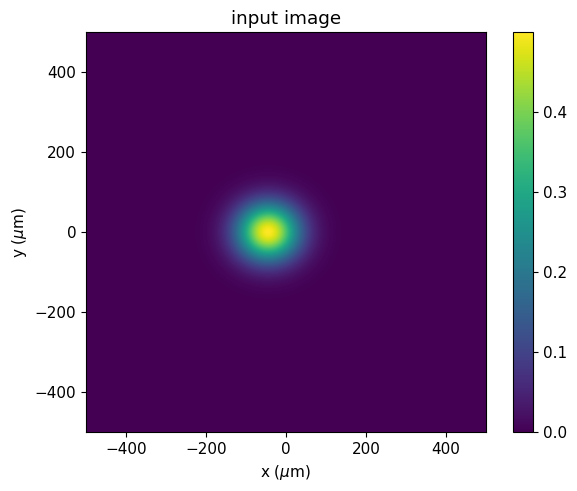

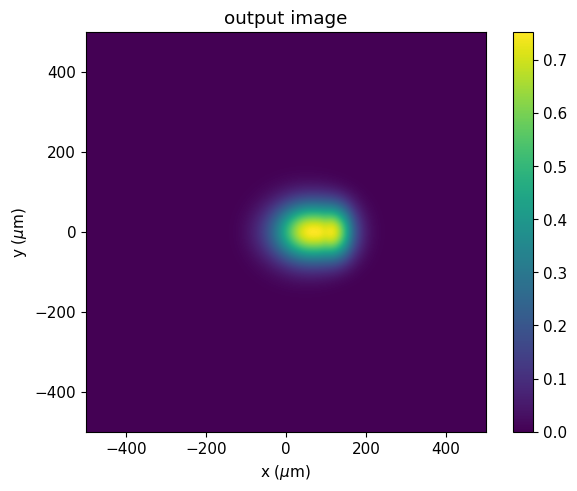

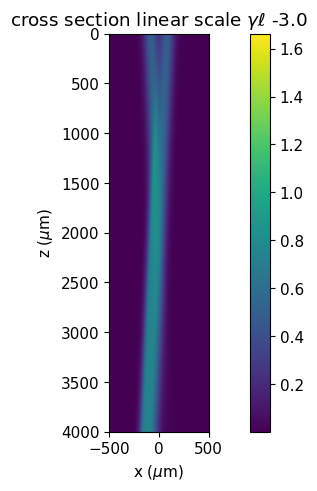

In [12]:
# @title  Display output
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["animation.html"] = "jshtml"
rcParams.update({'font.size': 11})

def func(xx, aa, bb): #exponential gain fit
    return aa * np.exp(-bb * xx) - aa

if timedep==0:
    tsteps=1
lbf=int(xsamp*(1-xaper/yaper*ysamp/xsamp)/2) #assuming yaper<xaper
luf=int(xsamp*(1+xaper/yaper*ysamp/xsamp)/2)


ixz=abs(ampxz)**2
ixz=np.where(ixz<0.0001,0.0001,ixz)

ixzf=ixz[-1] #not [0]

dx=xaper/xsamp
dy=yaper/ysamp
extent_crop=[dx*xl,dx*xh,dy*yl,dy*yh]

#fanning_mask
if w01 > 0:
  ws=min(w01,20) #minimum size of mask to cut remaining input beam
else:
    ws = 100

maskxp=int(xaper*(fx1+1/ws/2))+xsamp//2
maskxm=int(xaper*(fx1-1/ws/2))+xsamp//2
maskyp=int(yaper*(fy1+1/ws/2))+ysamp//2
maskym=int(yaper*(fy1-1/ws/2))+ysamp//2
mask=np.ones((xsamp,ysamp))
mask[maskxm:maskxp,maskym:maskyp]=0

if prdata['timedep']==True:

    try:
      if not fanning_study:
        imout_power=np.sum(imout,axis=(1,2))
        fig3 = plt.figure(figsize=(5, 5), dpi=100)
        ax6=fig3.add_subplot()
        ax6.set_xlabel('time, t0 units')
        ax6.set_ylabel('Output Power')
        #ax6.plot(t_seq.get(),gain_seq.get())
        ax6.plot(t_seq.get(),imr_norm.get())
        popt, pcov = curve_fit(func, t_seq.get(), gain_seq.get())
        tcstr='{0:.2f}'.format(1/popt[1])
        gstr='{0:.2f}'.format(-popt[0])
        ax6.set_title( r'input $\gamma$l '+str(gl)+'; fit $\gamma \ell$ ' +gstr+ '; time constant '+tcstr+ ' t0' )
        print('popt,pcov',popt,pcov)
    except:
      pass

 # try animation
 # cross section video
    ims=[]
    fig4 = plt.figure(figsize=(4, 5), dpi=100)
    ax10=fig4.add_subplot()
    ax10.set_xlabel('x mm')
    ax10.set_ylabel('y mm')
    ax10.set_title( r'cross section  $\gamma$l '+str(prdata['gl']))  # normal

    ixz=ixz/cp.max(ixz)
    for i in range(np.shape(ixz)[0]):
        im=ax10.imshow(ixz[i],
              extent=[-xaper/2000,xaper/2000,
              prdata['rlen']/1000,0],aspect=1,vmax=None)
        ims.append([im])
    cbar=fig4.colorbar(im,ax=ax10)
    ani1 = animation.ArtistAnimation(fig4, ims, interval=100, blit=True,
                                    repeat_delay=1000)  #fig4
    video=ani1.to_jshtml()
    html=ipydisplay.HTML(video)
    ipydisplay.display(html)
    plt.close(fig4)

#output image video
    ims=[]
    fig5 = plt.figure(figsize=(5, 5), dpi=100)

    ax11=fig5.add_subplot()
    ax11.set_xlabel(r'x ($\mu$m)')
    ax11.set_ylabel(r'y ($\mu$m)')
    ax11.set_title( r'output image $\gamma \ell$ '+str(prdata['gl']))
    ymax=yaper/1000/2/2
     # in mm 1st /2 is for half y aperture spanning,
     #2nd /2 is for zero centered yaper

    for i in range(np.shape(imout)[0]):

        im=ax11.imshow(abs(np.rot90(imout[i],k=3)),vmax=imout.max(),
         extent=extent_crop)
        ims.append([im])
    cbar=fig5.colorbar(im,ax=ax11)
    ani2 = animation.ArtistAnimation(fig5, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    video=ani2.to_jshtml()
    html=ipydisplay.HTML(video)
    ipydisplay.display(html)
    plt.close(fig5)

 #far field video

    #for i in range(len(iftg)):
    if fanning_study:
      ift2=ift*mask
      fig6 = plt.figure(figsize=(7, 5), dpi=100)
      ax12=fig6.add_subplot()
      ax12.set_xlabel( r'x spatial frequency ($\mu m^{-1}$)')
      ax12.set_ylabel( r'y freq ($\mu m^{-1}$)')
      ax12.set_title( r'far field $\gamma \ell$ '+str(prdata['gl']))
      ims=[]
      vmax_vid=np.max(ift2[-1])/1e8
      for i in range(np.shape(ift)[0]):
          im=ax12.imshow((ift2[i].T/1e8),extent=[-fxmax,fxmax,-fymax,fymax],
                          cmap='terrain',vmax=vmax_vid/2)

          ims.append([im])
      ani3 = animation.ArtistAnimation(fig6, ims, interval=100, blit=True,
                                      repeat_delay=1000)
      video=ani3.to_jshtml()
      html=ipydisplay.HTML(video)
      ipydisplay.display(html)
      plt.close(fig6)
      #if False:

      fig2a,ax5 = plt.subplots() #output far field
      ax5.set_xlabel( 'sin x propagation angle')
      ax5.set_ylabel('sin y propagation angle')
      ax5.set_title( r'far field $\gamma \ell$ '+str(prdata['gl']))
      ims=[]
      for i in range(np.shape(ift)[0]):


      #fanout_max=np.max(fanout)

        img=ax5.imshow(ift[i].T/(xsamp*ysamp),extent=[(-fxmax-fx1)*lm,(fxmax-fx1)*lm,-fymax*lm,fymax*lm]
                    ,vmax=6,cmap='terrain')
        ax5.set_xlim([-0.02,0.72])
        ax5.set_ylim([-0.25,0.25])
        cx,cy=0,0
        patch=Circle((cy,cx),radius=0.01,color='w')
        ax5.add_patch(patch)
        ims.append([img])
      ani3a = animation.ArtistAnimation(fig2a, ims, interval=100, blit=True,
                                      repeat_delay=1000)
      video=ani3a.to_jshtml()
      html=ipydisplay.HTML(video)
      ipydisplay.display(html)
      plt.close(fig2a)
      #ax5.set_title( r'fanning efficiency '+fanstr)


figin, ax1=plt.subplots()
ax1.set_title('input image')
ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel(r'y ($\mu$m)')
img=ax1.imshow(imin_final,extent=extent_crop)
cbar=figin.colorbar(img)

figout,ax4=plt.subplots()

ax4.set_title('output image')
ax4.set_xlabel(r'x ($\mu$m)')
ax4.set_ylabel(r'y ($\mu$m)')
if fanning_study:
  vm=0.5

else:
  vm=None
img=ax4.imshow(imout_final,extent=extent_crop,vmax=vm)
cbar=figin.colorbar(img)

fig1,ax2=plt.subplots()  # intensity cross section

ax2.set_title(r'cross section linear scale $\gamma \ell$ '+str(prdata['gl']))
ax2.set_xlabel(r'x ($\mu$m)')
ax2.set_ylabel(r'z ($\mu$m)')
img=ax2.imshow(ixz[-1],
          extent=[-xaper/2,xaper/2,prdata['rlen'],0],vmax=np.max(ixz[-1]))
cbar=figin.colorbar(img)

iftf=ift[-1] #output far field

vscale=xsamp/xaper*yaper/ysamp

if fanning_study:
    fig2,ax5 = plt.subplots() #output far field
    ax5.set_xlabel( r'x spatial frequency ($\mu m^{-1}$)')
    ax5.set_ylabel( r'y freq ($\mu m^{-1}$)')
    ax5.set_title( r'far field $\gamma \ell$ '+str(prdata['gl']))
    faneff=np.sum(mask*iftf)/np.sum(iftf)
    fanstr='{0:.2f}'.format(faneff)
    fanout=mask*iftf
    fanout_max=np.max(fanout)
    if ff_vmax is None:

      img=ax5.imshow(fanout.T/(xsamp*ysamp)**2,extent=[-fxmax,fxmax,-fymax,fymax],vmax=None,cmap='terrain')
    else:
      img=ax5.imshow(fanout.T/(xsamp*ysamp)**2,extent=[-fxmax,fxmax,-fymax,fymax],vmax=ff_vmax,cmap='terrain')

    #ax5.set_title( r'fanning efficiency '+fanstr)
    cbar=figin.colorbar(img,location='bottom')
    print('fanning efficiency',faneff)



Special code for analyzing time constants from Horowitz et al J. Opt. Soc. Am B vol. 8 p. 2204 (1991)

In [13]:
#p278=imr_norm.get()*(1+rat*np.exp(-2*2.644))/(1+rat*np.exp(2*gl))
#p330=imr_norm.get()*(1+rat*np.exp(-2*3.139))/(1+rat*np.exp(2*gl))
#p172=imr_norm.get()*(1+rat*np.exp(-2*1.636))/(1+rat*np.exp(2*gl))

In [14]:
#plt.plot(t_seq.get()*(1+(kg/k0)**2),p172, color='r')
#plt.plot(t_seq.get()*(1+(kg/k0)**2),p278,color='b')
#plt.plot(t_seq.get()*(1+(kg/k0)**2),p330,color='g')
#plt.ylim(0,1)
#plt.xlabel('time, t0/(1+$(k_g/k_0)^2$) units')
#plt.ylabel('Normalized Output Power')
#plt.legend(['$\gamma \ell$ = 1.72','$\gamma \ell$ = 2.78','$\gamma \ell$ = 3.3'])
#plt.plot()

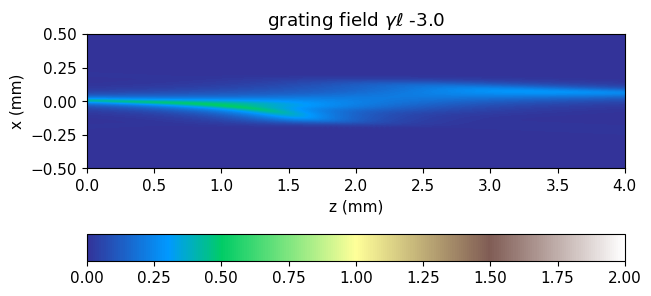

In [15]:
# @ title show grating cross section
plt.imshow(np.flip(abs(escsxz[-1]).T,axis=0),
              extent=[0,prdata['rlen']/1000,-xaper/2000,+xaper/2000,
              ],cmap='terrain',vmax=2)
plt.title(r'grating field $\gamma \ell$ '+str(prdata['gl']))
plt.xlabel(r'z (mm)')
plt.ylabel(r'x (mm)')
plt.colorbar(location='bottom')

In [16]:
# @ title Save data if requested in save data checkbox
if savedata:
  from google.colab import drive
  drive.mount('/content/drive')
  pathf='/content/drive/MyDrive/'+folder
  if not os.path.isdir(pathf):
    os.mkdir(pathf)
  plt.figure(figin)
  plt.savefig(pathf+'/image_in.png',bbox_inches='tight')
  plt.figure(figout)
  plt.savefig(pathf+'/image_out.png',bbox_inches='tight')
  plt.figure(fig1)
  plt.savefig(pathf+'/xsection.png',bbox_inches='tight')
  if fanning_study:
    plt.figure(fig2)
    plt.savefig(pathf+'/farfield.png',bbox_inches='tight')

  np.savez_compressed(pathf+"/data",prdata)
  fylo=max(-0.6,-fymax)
  fyhi=min(0.6,fymax)
  fxlo=max(-0.6,-fxmax)
  fxhi=min(0.6,fxmax)
  xpxmin=int(fxlo*xaper+xsamp/2)
  xpxmax=int(fxhi*xaper+xsamp/2-1)
  ypxmin=int(fylo*yaper+ysamp/2)
  ypxmax=int(fyhi*yaper+ysamp/2-1)

  if fanning_study:
   iftmasked=mask*ift[-1]
  else:
    iftmasked=ift[-1]
  fig,ax = plt.subplots()
  img=ax.imshow(iftmasked[xpxmin:xpxmax,ypxmin:ypxmax].T/1e8,extent=[fxlo*lm,fxhi*lm,fylo*lm,fyhi*lm],cmap='terrain',vmax=6)
  ax.set_xlabel( r'sin x propagation angle')
  ax.set_ylabel( r'sin y propagation angle')
  ax.set_title( r' far field $\gamma \ell$ '+str(prdata['gl']))
  #fig.colorbar(img,location='bottom')
  plt.figure(fig)
  plt.savefig(pathf+'/ffcompact.png',bbox_inches='tight')
  if timedep:
    writervideo=animation.FFMpegWriter(fps=5)
    ani1.save(filename=pathf+"/ixz.mp4")
    ani2.save(filename=pathf+"/imout.mp4")
    if fanning_study:
      ani3.save(filename=pathf+"/farfield.mp4")
      ani3a.save(filename=pathf+"/farfield_compact.mp4")


In [17]:
#check energy conservation
np.sum(abs(amp.get())**2)/np.sum(abs(amp0.get())**2)

0.9999996057628928

<ipython-input-18-7970517375c3>:20: UserWarning: The figure layout has changed to tight
  fig.tight_layout()  # otherwise the right y-label is slightly clipped


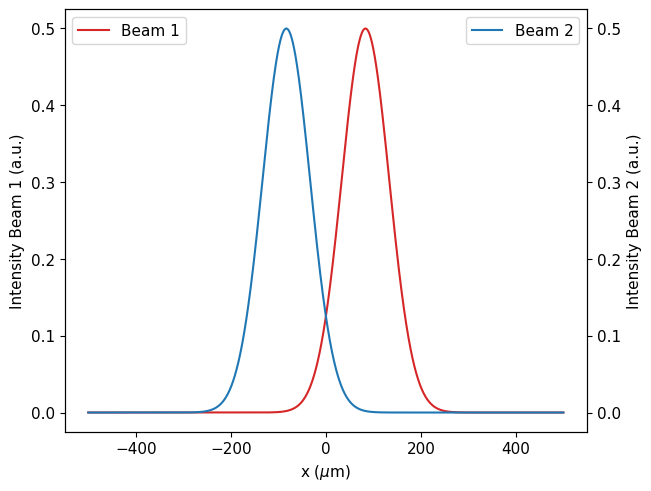

In [18]:
data1 = abs(amp0m.get()[:,ysamp//2])**2
data2 = abs(amp0p.get()[:,ysamp//2])**2

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel('Intensity Beam 1 (a.u.)')
ax1.plot(x.get(), data1, color=color)
ax1.tick_params(axis='y')
ax1.legend(['Beam 1'],loc='upper left')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Intensity Beam 2 (a.u.)')  # we already handled the x-label with ax1
ax2.plot(x.get(), data2, color=color)
ax2.tick_params(axis='y')
ax2.legend(['Beam 2'],loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

<ipython-input-19-88114af4973c>:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


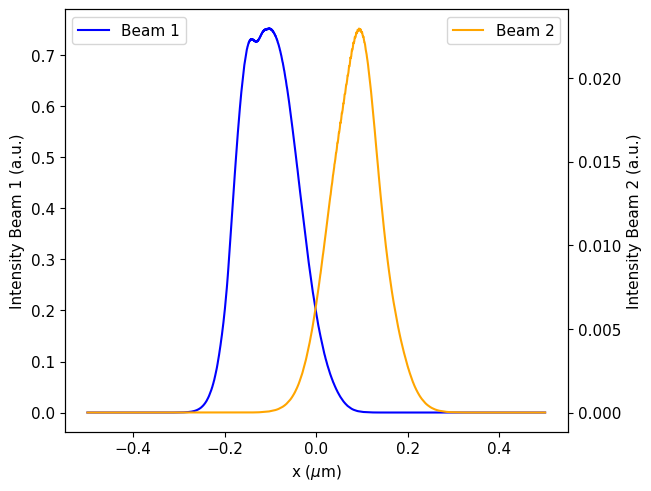

In [19]:
#out

data1 = abs(ampm.get()[:,ysamp//2])**2
data2 = abs(ampp.get()[:,ysamp//2])**2

fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel(r'x ($\mu$m)')
ax1.set_ylabel('Intensity Beam 1 (a.u.)')
ax1.plot(x.get()/1000, data1, color=color)
ax1.tick_params(axis='y')
ax1.legend(['Beam 1'],loc='upper left')
#plt.ylim([0,7])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color =  'orange' #'tab:blue'
ax2.set_ylabel('Intensity Beam 2 (a.u.)')  # we already handled the x-label with ax1
ax2.plot(x.get()/1000, data2, color=color)
ax2.tick_params(axis='y')
ax2.legend(['Beam 2'],loc='upper right')
#plt.ylim([0,7])
fig.tight_layout()
plt.show()

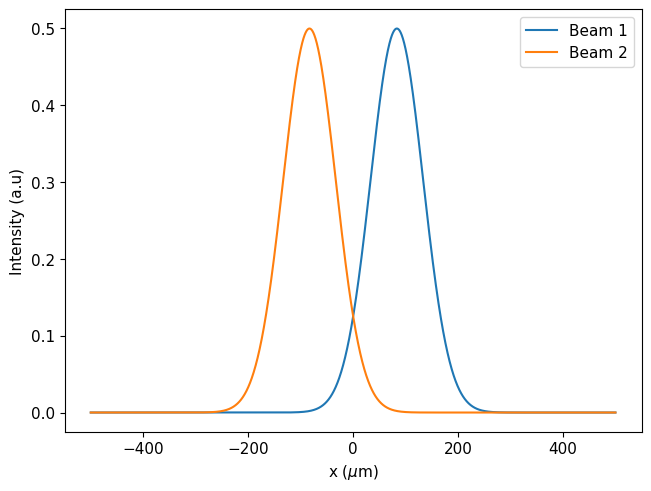

In [20]:
#input beams
plt.plot(x.get(),abs(amp0m.get()[:,ysamp//2])**2)
plt.plot(x.get(),abs(amp0p.get()[:,ysamp//2])**2)
#plt.ylim(0,1)
#plt.xlim(-250,250)
plt.legend(['Beam 1','Beam 2'])
plt.xlabel(r'x ($\mu$m)')
plt.ylabel('Intensity (a.u)')
plt.show()

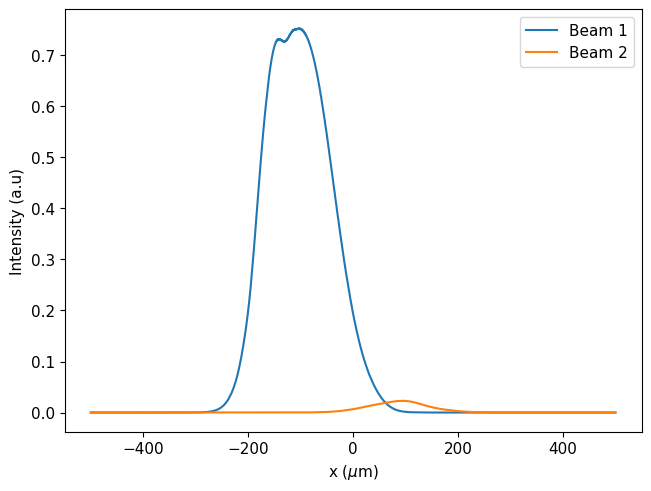

In [21]:
#output beams
plt.plot(x.get(),abs(ampm.get()[:,ysamp//2])**2)
plt.plot(x.get(),abs(ampp.get()[:,ysamp//2])**2)
#plt.ylim(0,1)
#plt.xlim(-250,250)
plt.legend(['Beam 1','Beam 2'])
plt.xlabel(r'x ($\mu$m)')
plt.ylabel('Intensity (a.u)')
plt.show()

In [22]:
#fanning efficiency
if fanning_study:
  print('Fanning efficiency ', faneff)

In [23]:
if timedep and fanning_study:
  isum_full=np.sum(abs(ampout)**2,axis=(1,2))
  inorm=isum_full[0]
  isum_full=isum_full/isum_full[0]
  plt.plot(t_seq.get()[::4],isum_full)
  plt.xlabel('time, t0 units')
  plt.ylabel('Output Power')
  plt.title( r' $\gamma \ell$ '+str(prdata['gl'])+' waist '+str(prdata['w01'])+' $\mu m$ ')
  #plt.title( r' $\gamma \ell$ '+str(prdata['gl']+' waist '+str(prdata['w01'])))

In [24]:
if timedep and fanning_study:
  isum=np.sum(ift,axis=(1,2))
  isum=isum/inorm/(xsamp*ysamp)
  plt.plot(t_seq.get()[::4],isum)
  plt.xlabel('time, t0 units')
  plt.ylabel('Output Power')
  plt.title( r' $\gamma \ell$ '+str(prdata['gl'])+' waist '+str(prdata['w01'])+' $\mu m$ ')
  #plt.title( r' $\gamma \ell$ '+str(prdata['gl']+' waist '+str(prdata['w01'])))